# Diffusion Model 2D Example

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.chi2 import Chi2

from ddpm_2d import ddpm, datasets

from torch_geometry.manifolds import nEuclidean, LambdaManifold
from torch_geometry.prob_geodesics import ProbGEORCE_Euclidean_Adaptive, ProbScoreGEORCE_Euclidean
from torch_geometry.prob_means import ProbScoreGEORCEFM_Euclidean

#from torch_geometry.prob_means import ProbGEORCEFM, ProbGEORCEFM_Embedded, ProbGEORCEFM_Euclidean
#from torch_geometry.prob_means import ProbGEORCEFM_Adaptive, ProbGEORCEFM_Embedded_Adaptive, ProbGEORCEFM_Euclidean_Adaptive

## Hyper-parameters

In [2]:
M = nEuclidean(dim=2)

In [3]:
dataset_name = "dino"
n_points = 50_00
train_model = False

lam = 10.0
lr_rate=0.01
beta1=0.5
beta2=0.5
eps=1e-8
reg_type = "normal"

max_iter = 1000
sub_iter = 100
tol = 1e-4
N_grid = 100
grid_size = 100

In [4]:
model_path = '../models/gen2d/'
device = 'cpu'

In [5]:
num_timesteps = 100
plot_step = 25
eval_batch_size = 10_000
figure_path = "../figures/gen2d/"

In [6]:
torch.manual_seed(2712)

### Displaying forward process

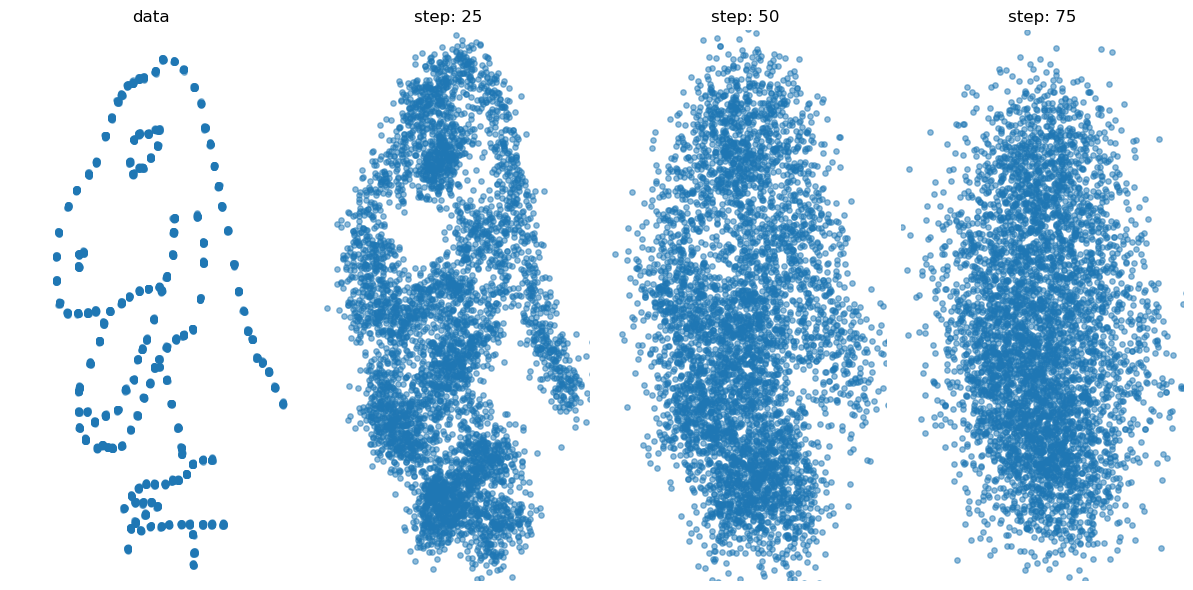

In [7]:
num_plots = math.ceil(num_timesteps / plot_step)
num_cols = 5
num_rows = math.ceil(num_plots / num_cols)

fig = plt.figure(figsize=(15, 6))

noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
dataset = datasets.get_dataset(dataset_name, n=n_points)
x0 = dataset.tensors[0]

plt_cnt = 1
plt.subplot(num_rows, num_cols, plt_cnt)
plt.scatter(x0[:, 0], x0[:, 1], alpha=0.5, s=15)
plt.title("data")
plt.xlim(-3.5, 3.5)
plt.ylim(-4., 4.75)
plt.axis("off")
        
for t in range(len(noise_scheduler)):
    timesteps = np.repeat(t, len(x0))
    noise = torch.randn_like(x0)
    sample = noise_scheduler.add_noise(x0, noise, timesteps)
    if (t + 1) % plot_step == 0 and (t + 1) != len(noise_scheduler):
        plt_cnt += 1
        plt.subplot(num_rows, num_cols, plt_cnt)
        plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=15)
        plt.title(f"step: {t + 1}")
        plt.xlim(-3.5, 3.5)
        plt.ylim(-4., 4.75)
        plt.axis("off")
        
fig.tight_layout()
#plt.savefig("static/forward.png", facecolor="white")
plt.show()

### Plotting reverse model

In [8]:
if train_model:
    !python ddpm.py --experiment_name dino_base

In [9]:
model = ddpm.MLP()

path = "../models/gen2d/ddpm/dino_model.pth"
model.load_state_dict(torch.load(path))
model.eval()

MLP(
  (time_mlp): PositionalEmbedding(
    (layer): SinusoidalEmbedding()
  )
  (input_mlp1): PositionalEmbedding(
    (layer): SinusoidalEmbedding()
  )
  (input_mlp2): PositionalEmbedding(
    (layer): SinusoidalEmbedding()
  )
  (joint_mlp): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Block(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): GELU(approximate='none')
    )
    (3): Block(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): GELU(approximate='none')
    )
    (4): Block(
      (ff): Linear(in_features=128, out_features=128, bias=True)
      (act): GELU(approximate='none')
    )
    (5): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [10]:
noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
sample = torch.randn(eval_batch_size, 2)
timesteps = list(range(num_timesteps))[::-1]
samples = []
steps = []

samples.append(sample)
steps.append(0)
for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
    with torch.no_grad():
        residual = model(sample, t)
    sample = noise_scheduler.step(residual, t[0], sample)
    if (i + 1) % plot_step == 0:
        samples.append(sample.numpy())
        steps.append(i + 1)

  0%|          | 0/100 [00:00<?, ?it/s]

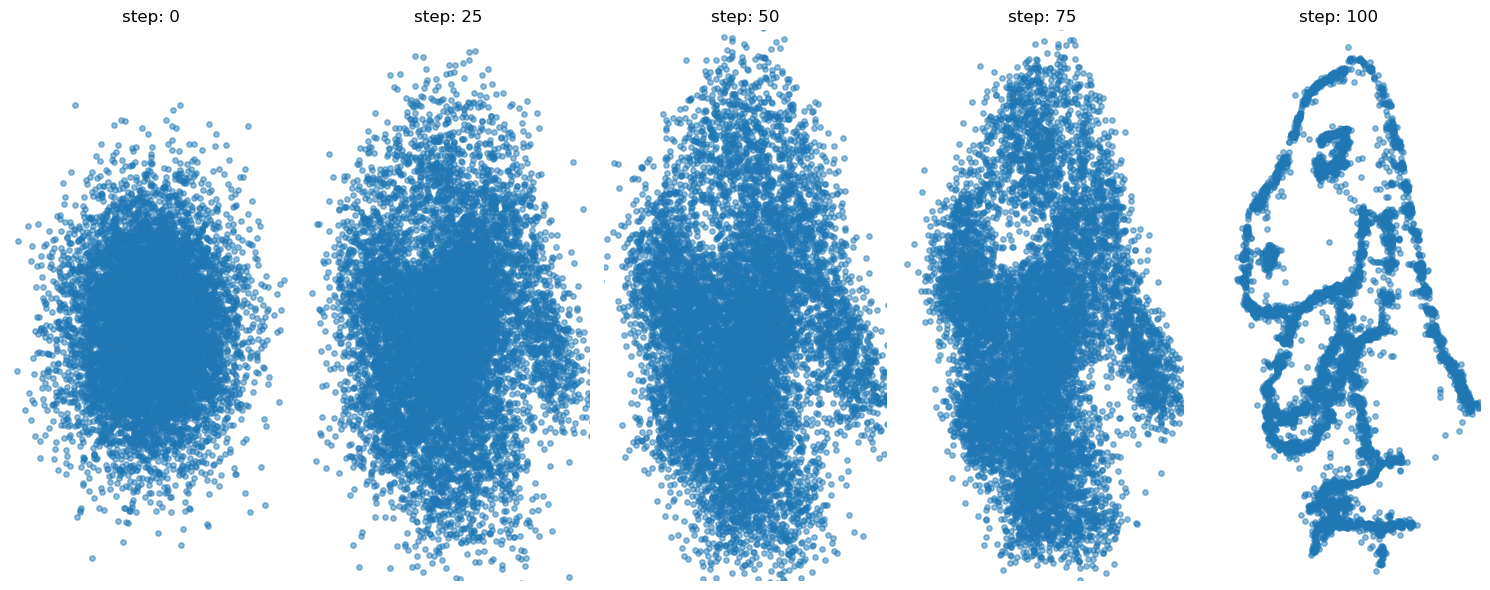

In [11]:
num_cols = 5
num_rows = math.ceil(len(samples) / num_cols)
fig = plt.figure(figsize=(15, 6))
for i, sample in enumerate(samples):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=15)
    plt.title(f"step: {steps[i]}")
    plt.xlim(-3.5, 3.5)
    plt.ylim(-4., 4.75)
    plt.axis("off")
fig.tight_layout()
#plt.savefig("static/reverse.png", facecolor="white")
plt.show()

## Plotting interpolation

In [12]:
S_normal = MultivariateNormal(torch.zeros(2), scale_tril=torch.diag(torch.ones(2)))
S_chi2 = Chi2(2)

def reg_normal_fun(x):

    return -torch.sum(S_normal.log_prob(x))

def reg_chi2_fun(x):
    
    return -torch.sum(S_chi2.log_prob(torch.sum(x**2, axis=-1)))

In [13]:
if reg_type == "normal":
    reg_fun = reg_normal_fun
elif reg_type == "chi2":
    reg_fun = reg_chi2_fun

In [14]:
@torch.no_grad()
def score_fun(x,t):
    if x.ndim == 1:
        t = torch.from_numpy(np.repeat(t, 1)).long()
        return -noise_scheduler.score(x.reshape(-1,2), t, model)
    elif x.ndim == 2:
        t = torch.from_numpy(np.repeat(t, len(x))).long()
        return -noise_scheduler.score(x, t, model)
    elif x.ndim > 2:
        shape = x.shape
        t = torch.from_numpy(np.repeat(t, len(x.reshape(-1,2)))).long()
        score = -noise_scheduler.score(x.reshape(-1,2), t, model)
        return score.reshape(*shape)

In [15]:
end_points = torch.randn(2, 2)

In [16]:
end_points = torch.tensor([[-0.50, -0.5],
                           [0.50, 0.5]])

In [17]:
noise_end_points = torch.randn((num_timesteps, 2, 2))
noise_curves_points = torch.randn((num_timesteps, N_grid+1, 2))

### Iterative optimization

In [18]:
noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
timesteps = list(range(num_timesteps))[::-1]
iterative_steps = []
iterative_curves = []

geodesic = ProbGEORCE_Euclidean_Adaptive(reg_fun = reg_fun,
                                         init_fun=None,
                                         lam=lam,
                                         N=N_grid,
                                         tol=tol,
                                         max_iter=max_iter,
                                         lr_rate=lr_rate,
                                         beta1=beta1,
                                         beta2=beta2,
                                         eps=eps,
                                         device=device,
                                        )
new_curve = geodesic(end_points[0], end_points[1])

iterative_steps.append(0)
iterative_curves.append(new_curve)
for i, t in enumerate(tqdm(timesteps)):
    with torch.no_grad():
        residual_bvp = model(end_points, torch.from_numpy(np.repeat(t, 2)).long())
    end_points = noise_scheduler.step(residual_bvp, t, end_points, noise=noise_end_points[i])

    geodesic = ProbScoreGEORCE_Euclidean(score_fun = lambda x: score_fun(x,t),
                                         init_fun=lambda x,y,t: new_curve[1:-1],
                                         lam=lam,
                                         N=N_grid,
                                         tol=tol,
                                         max_iter=sub_iter,
                                         lr_rate=lr_rate,
                                         beta1=beta1,
                                         beta2=beta2,
                                         eps=eps,
                                         device=device,
                                        )
    new_curve = geodesic(end_points[0], end_points[1])

    
    if (i + 1) % plot_step == 0:
        iterative_curves.append(new_curve)
        iterative_steps.append(i + 1)
        
#last_curve = iterative_curves[-1]
#with torch.no_grad():
#    residual_bvp = model(last_curve, torch.from_numpy(np.repeat(t, len(last_curve))).long())
#last_curve = noise_scheduler.step(residual_bvp, t, last_curve, noise=noise_curves_points[-1])
#iterative_curves[-1] = last_curve

  0%|          | 0/100 [00:00<?, ?it/s]

### Data space optimization

In [19]:
noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
timesteps = list(range(num_timesteps))[::-1]
iterative_steps = []
data_curves = []

for i, t in enumerate(tqdm(timesteps)):
    with torch.no_grad():
        residual_bvp = model(end_points, torch.from_numpy(np.repeat(t, 2)).long())
    end_points = noise_scheduler.step(residual_bvp, t, end_points, noise=noise_end_points[i])

geodesic = ProbScoreGEORCE_Euclidean(score_fun = lambda x: score_fun(x,t),
                                     init_fun=None,
                                     lam=lam,
                                     N=N_grid,
                                     tol=tol,
                                     max_iter=max_iter,
                                     lr_rate=lr_rate,
                                     beta1=beta1,
                                     beta2=beta2,
                                     eps=eps,
                                     device=device,
                                    )
new_curve = geodesic(end_points[0], end_points[1])

for i in range(plot_step):
    data_curves.append(new_curve)

#last_curve = data_curves[-1]
#with torch.no_grad():
#    residual_bvp = model(last_curve, torch.from_numpy(np.repeat(t, len(last_curve))).long())
#last_curve = noise_scheduler.step(residual_bvp, t, last_curve, noise=noise_curves_points[-1])
#data_curves[-1] = last_curve

  0%|          | 0/100 [00:00<?, ?it/s]

### Noise Interpolation

In [20]:
noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
timesteps = list(range(num_timesteps))[::-1]
interpolation_steps = []
noise_curves = []

geodesic = ProbGEORCE_Euclidean_Adaptive(reg_fun = reg_fun,
                                         init_fun=None,
                                         lam=lam,
                                         N=N_grid,
                                         tol=tol,
                                         max_iter=max_iter,
                                         lr_rate=lr_rate,
                                         beta1=beta1,
                                         beta2=beta2,
                                         eps=eps,
                                         device=device,
                                        )
new_curve = geodesic(end_points[0], end_points[1])

interpolation_steps.append(0)
noise_curves.append(new_curve)
for i, t in enumerate(tqdm(timesteps)):
    with torch.no_grad():
        residual_bvp = model(new_curve, torch.from_numpy(np.repeat(t, len(new_curve))).long())
    new_curve = noise_scheduler.step(residual_bvp, t, new_curve, noise_curves_points[i])

    if (i + 1) % plot_step == 0:
        noise_curves.append(new_curve)
        interpolation_steps.append(i + 1)

  0%|          | 0/100 [00:00<?, ?it/s]

### Plotting Interpolation

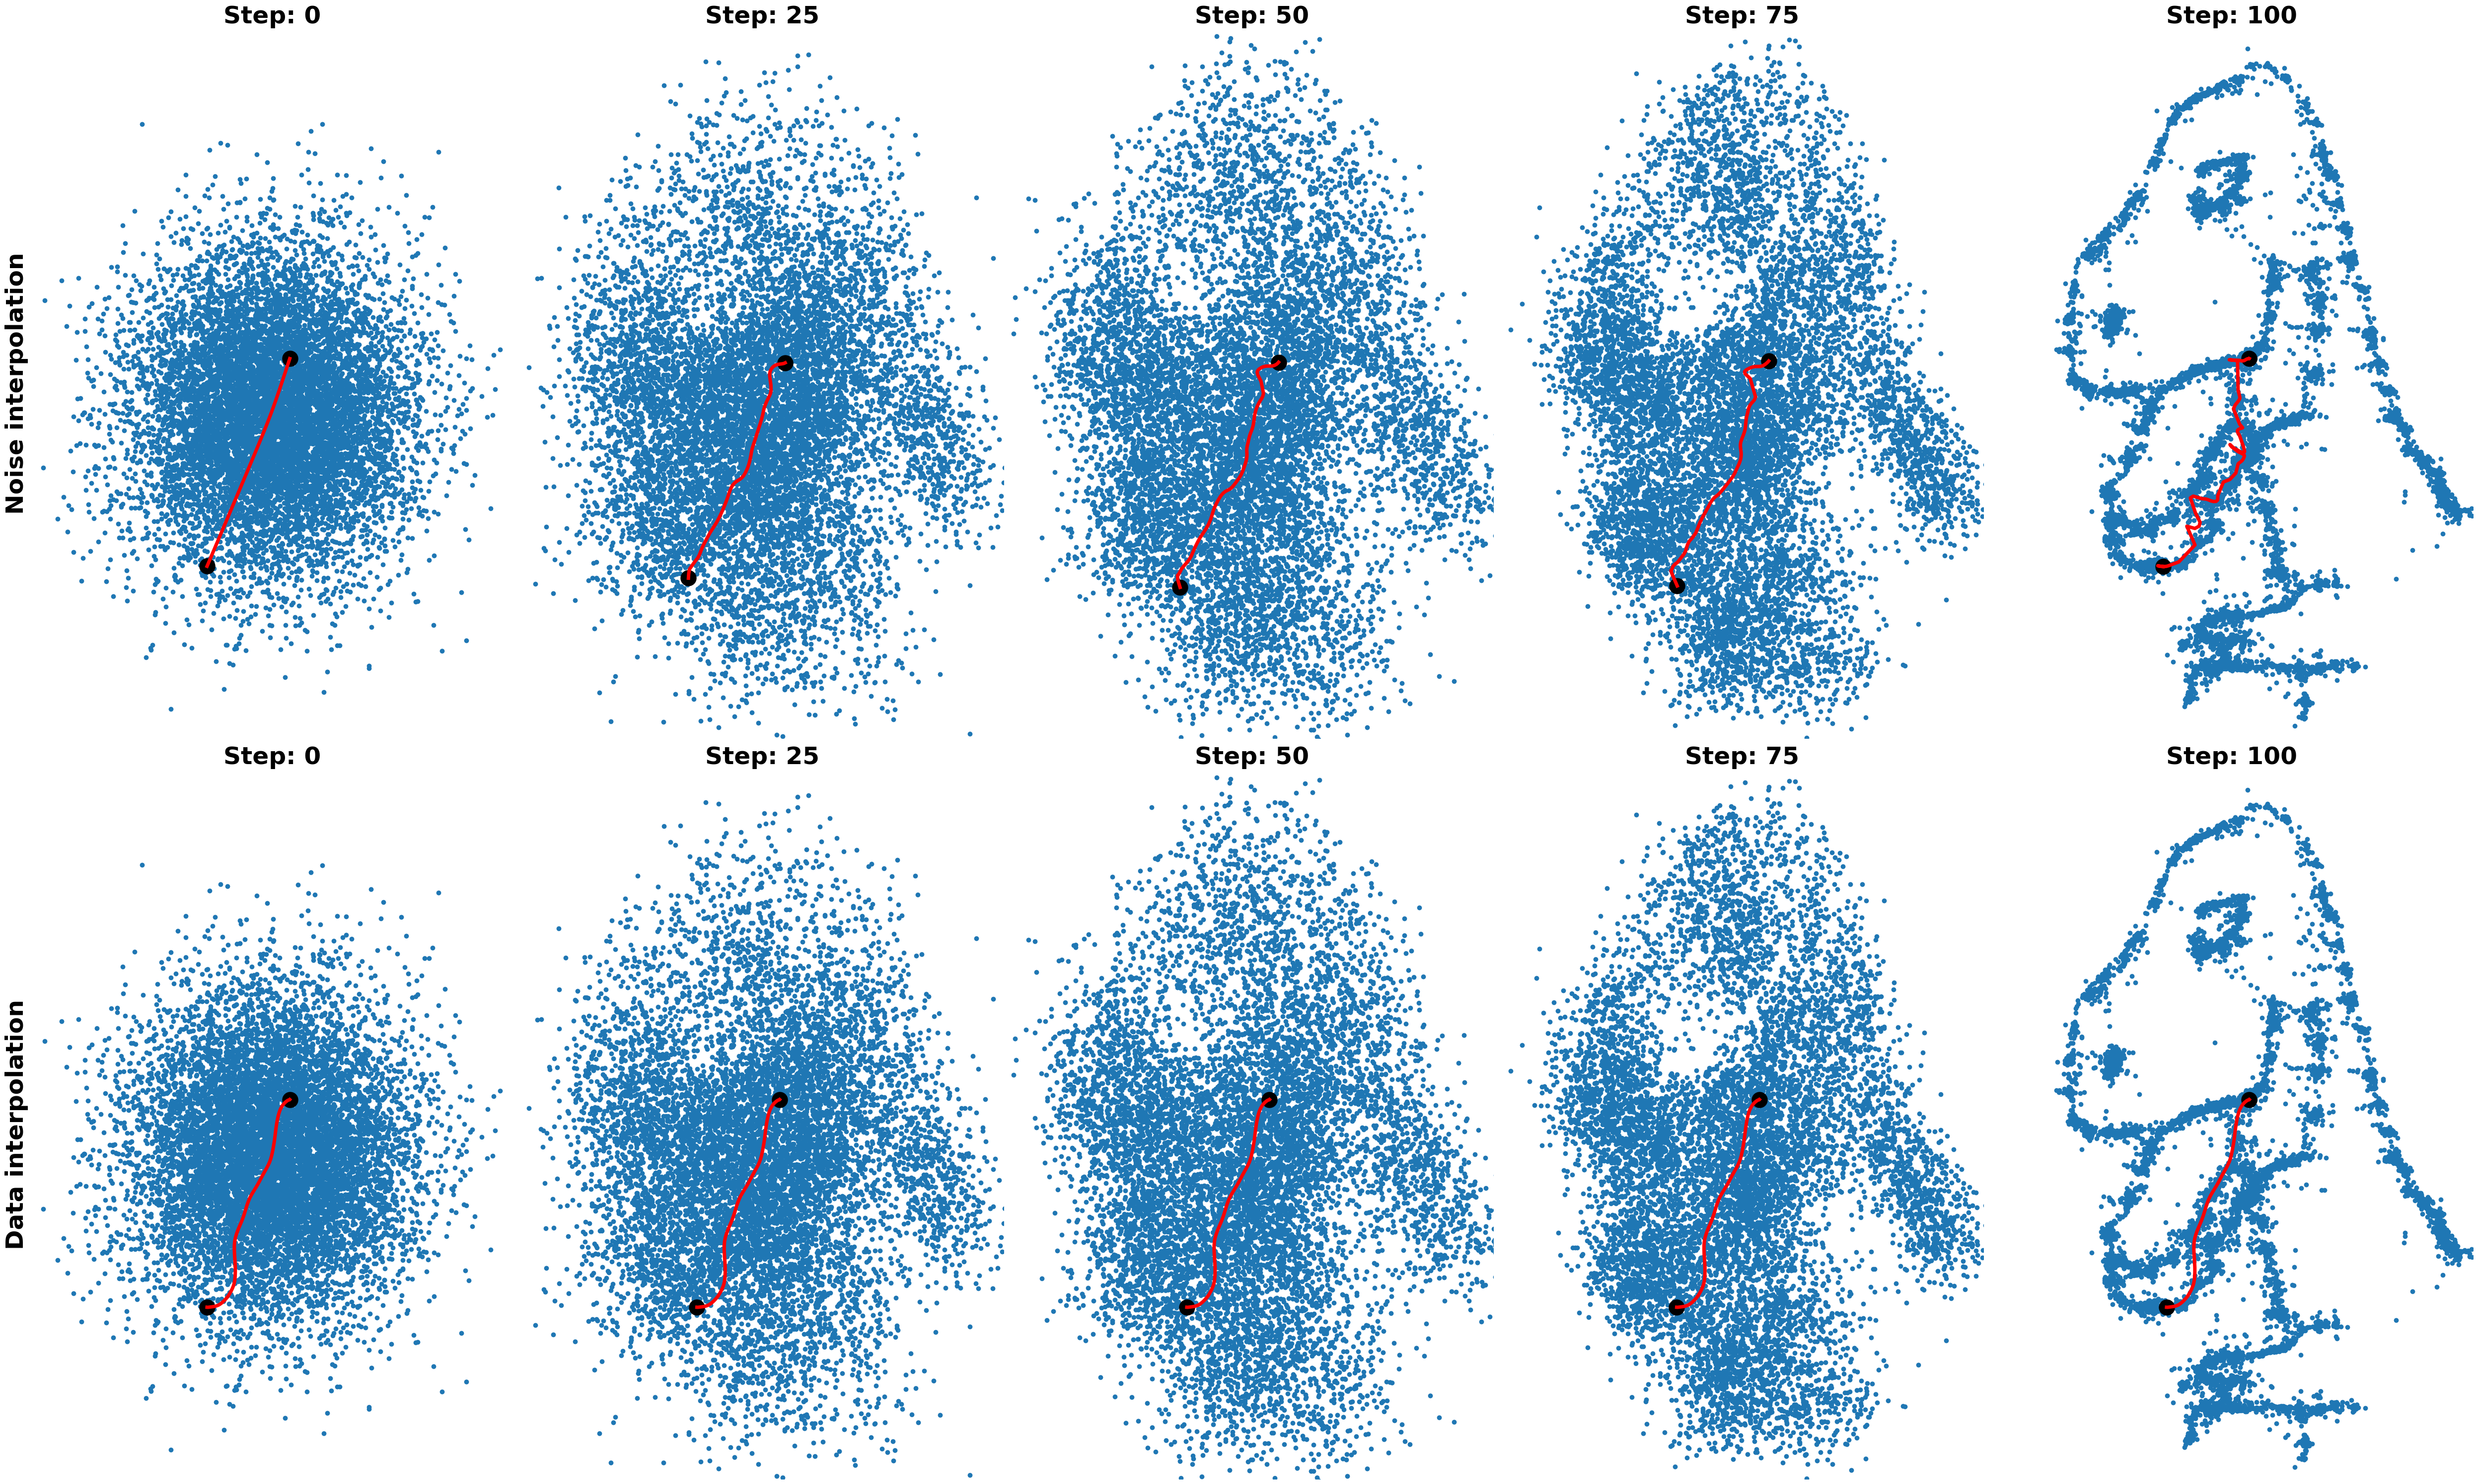

In [21]:
num_cols = 5
num_rows = math.ceil(len(samples) / num_cols)

fig = plt.figure(figsize=(len(noise_curves)*10,3*10))

for i, sample in enumerate(samples):
    ax = fig.add_subplot(2, len(noise_curves), i+1)
    ax.scatter(sample[:,0], sample[:,1])
    ax.scatter(noise_curves[i][0,0], noise_curves[i][0,1], color="black", s=500)
    ax.scatter(noise_curves[i][-1,0], noise_curves[i][-1,1], color="black", s=500)
    ax.plot(noise_curves[i][:,0], noise_curves[i][:,1], color="red",  linewidth=5.0)
    ax.set_title(f"Step: {steps[i]}", fontweight="bold", fontsize=35)
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-4., 4.75)

    # Hide everything except label
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    if i == 0:
        ax.set_ylabel("Noise interpolation",
                      rotation="vertical",
                      fontweight="bold",
                      fontsize=35)

#for i, sample in enumerate(samples):
#    ax = fig.add_subplot(3, len(noise_curves), i+1+len(noise_curves))
#    ax.scatter(sample[:,0], sample[:,1])
#    ax.plot(iterative_curves[i][:,0], iterative_curves[i][:,1], color="red", linewidth=5.0)
#    ax.set_title(f"Step: {steps[i]}", fontweight="bold", fontsize=35)
#    ax.set_xlim(-3.5, 3.5)
#    ax.set_ylim(-4., 4.75)

    # Hide everything except label
#    ax.set_xticks([])
#    ax.set_yticks([])
#    for spine in ax.spines.values():
#        spine.set_visible(False)

#    if i == 0:
#        ax.set_ylabel("Iterative interpolation",
#                      rotation="vertical",
#                      fontweight="bold",
#                      fontsize=35)

for i, sample in enumerate(samples):
    ax = fig.add_subplot(2, len(noise_curves), i+1+1*len(noise_curves))
    ax.scatter(sample[:,0], sample[:,1])
    ax.scatter(data_curves[i][0,0], data_curves[i][0,1], color="black", s=500)
    ax.scatter(data_curves[i][-1,0], data_curves[i][-1,1], color="black", s=500)
    ax.plot(data_curves[i][:,0], data_curves[i][:,1], color="red", linewidth=5.0)
    ax.set_title(f"Step: {steps[i]}", fontweight="bold", fontsize=35)
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-4., 4.75)

    # Hide everything except label
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    if i == 0:
        ax.set_ylabel("Data interpolation",
                      rotation="vertical",
                      fontweight="bold",
                      fontsize=35)
        

fig.tight_layout()
plt.savefig(''.join((figure_path, "ddpm_2d_data_noise_sampling.pdf")), facecolor="white")
plt.show()

## Plotting ODE

In [22]:
timesteps = list(range(num_timesteps))[::-1]
Mlambda = LambdaManifold(M=M, S=None, gradS=lambda x: score_fun(x.reshape(-1,2),timesteps[-1]).squeeze(), lam=lam)

In [23]:
theta = torch.linspace(0, 2*torch.pi,10)
v = 10.0*torch.stack([torch.cos(theta), torch.sin(theta)]).T
ode_curve = torch.stack([Mlambda.Exp_ode(end_points[-1], v0) for v0 in v]).detach().numpy()

### Plotting Fréchet Mean

In [24]:
data_sample = torch.stack([torch.from_numpy(s) for s in samples[-1][:100]])

In [25]:
timesteps = list(range(num_timesteps))[::-1]
prob_mean_adaptive = ProbScoreGEORCEFM_Euclidean(score_fun=lambda x: score_fun(x,timesteps[-1]),
                                                 init_fun=None,
                                                 lam=lam,
                                                 N_grid=N_grid,
                                                 tol=tol,
                                                 max_iter=max_iter,
                                                 lr_rate=lr_rate,
                                                 beta1=beta1,
                                                 beta2=beta2,
                                                 eps=eps,
                                                 device=device,
                                                )

In [26]:
z_mu, zi = prob_mean_adaptive(data_sample)

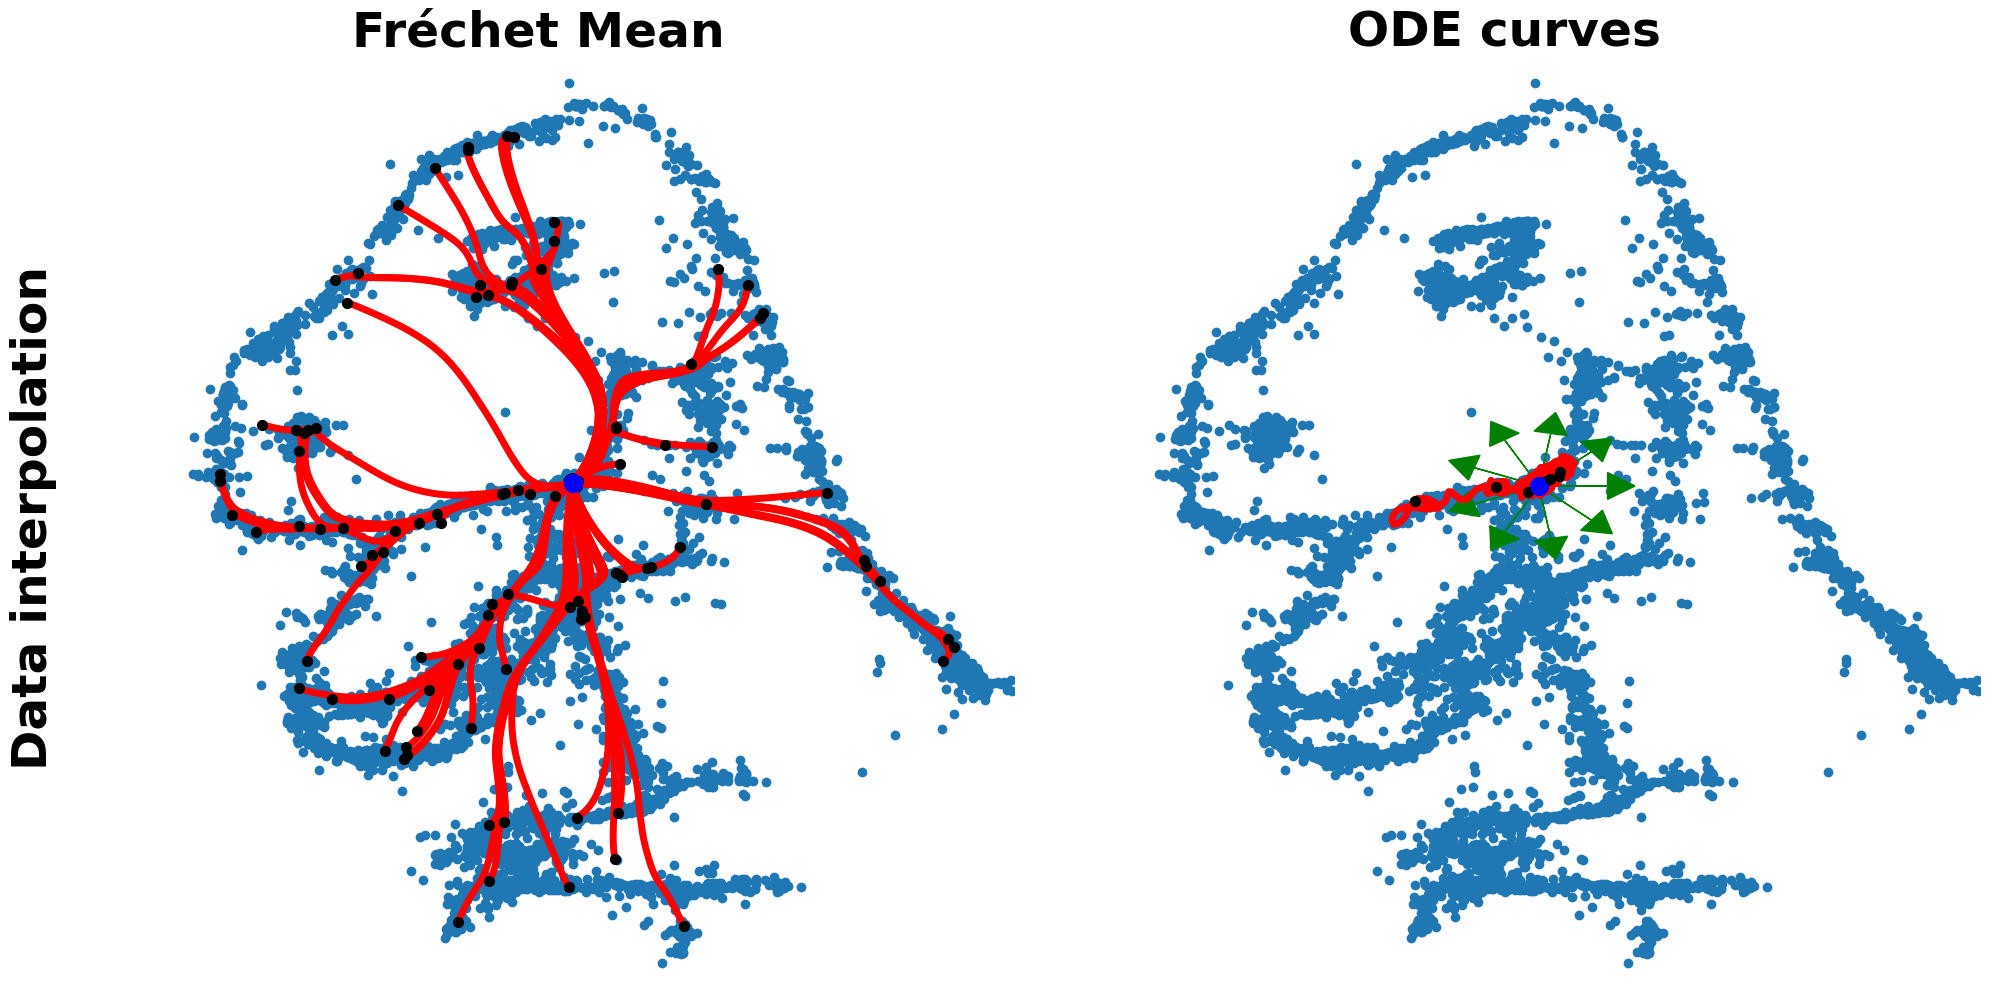

In [27]:
fig = plt.figure(figsize=(20,10))

# =====================
#    FRECHET MEAN
# =====================
ax = fig.add_subplot(121)
ax.scatter(samples[-1][:,0], samples[-1][:,1])

# Mark Frechet mean
ax.scatter(z_mu[0], z_mu[1], color="black", s=200, label="Fréchet mean")

# --- NEW: plot initial points of curves (start of each curve) ---
for curve in zi:
    ax.scatter(curve[0,0], curve[0,1], color="blue", s=150, zorder=5)  # starting point
    ax.scatter(curve[-1,0], curve[-1,1], color="black", s=50, zorder=5)  # starting point
    ax.plot(curve[:,0], curve[:,1], color="red", linewidth=5.0)

ax.set_title("Fréchet Mean", fontweight="bold", fontsize=35)
ax.set_xlim(-3.5, 3.5)
ax.set_ylim(-4., 4.75)

# Hide everything except label
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_ylabel("Data interpolation",
              rotation="vertical",
              fontweight="bold",
              fontsize=35)

# =====================
#     ODE SAMPLING
# =====================
ax = fig.add_subplot(122)
ax.scatter(samples[-1][:,0], samples[-1][:,1])

# Mark the ODE starting point
x0, y0 = end_points[-1]
ax.scatter(x0, y0, color="black", s=200, label="ODE start")

# --- NEW: display initial direction vectors ---
# v has shape (10, 2)
scale = 0.8  # you can adjust this factor if arrows too long/short
v /= torch.linalg.norm(v)
v *= 2.0
for direction in v:
    ax.arrow(x0, y0,
             scale * direction[0],
             scale * direction[1],
             head_width=0.25, head_length=0.2,
             fc='green', ec='green')

# Plot ODE curves
for curve in ode_curve:
    ax.scatter(curve[0,0], curve[0,1], color="blue", s=150, zorder=5)  # starting point
    ax.plot(curve[:,0], curve[:,1], color="red", linewidth=5.0)
    ax.scatter(curve[-1,0], curve[-1,1], color="black", s=50, zorder=5)  # starting point

ax.set_title("ODE curves", fontweight="bold", fontsize=35)
ax.set_xlim(-3.5, 3.5)
ax.set_ylim(-4., 4.75)

# Hide all ticks/spines
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

fig.tight_layout()
plt.savefig(''.join((figure_path, "ddpm_2d_fmean_ode.pdf")), facecolor="white")
plt.show()
